### 1. Importing libraries / Data Loading and Splitting



In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt

from torchvision import datasets, models, transforms
from os import rename, listdir, path
import math
import shutil

torch.manual_seed(1) # set the random seed

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) #Must have folder inside drive called PokeScanner

data_transform = transforms.Compose([
    # you can add other transformations in this list
    #transforms.Resize(250),
    transforms.ToTensor()
])

Mounted at /content/gdrive


In [2]:
use_cuda = True
# filePath = '/content/gdrive/MyDrive/PokeScanner' #Everyone has had this folder shared with them, Right click the folder and click "Add shortcut to Drive"

# i = 0
# j = 0
# items = listdir("/content/gdrive/MyDrive/PokeScanner/PokemonDataCleaned")
# print(items)
# for i in range (0, len(items)):
#   if (os.path.isdir("/content/gdrive/MyDrive/PokeScanner/PokemonDataCleaned/"+ items[i])):
#     dirItems = listdir("/content/gdrive/MyDrive/PokeScanner/PokemonDataCleaned/"+ items[i])
#     trainingNumber = math.floor(len(dirItems) * 0.80) 
#     validationNumber = math.floor(len(dirItems) * 0.10)
#     for j in range (0, len(dirItems)):
#      if (os.path.isfile("/content/gdrive/MyDrive/PokeScanner/PokemonDataCleaned/" + items[i] + "/" + dirItems[j])):
#        if (j <= trainingNumber):
#         shutil.copyfile("/content/gdrive/MyDrive/PokeScanner/PokemonDataCleaned/" + items[i] + "/" + dirItems[j], "/content/gdrive/MyDrive/PokeScanner/Training/" + items[i] + "/" + dirItems[j])
#        elif (j <= trainingNumber + validationNumber):
#         shutil.copyfile("/content/gdrive/MyDrive/PokeScanner/PokemonDataCleaned/" + items[i] + "/" + dirItems[j], "/content/gdrive/MyDrive/PokeScanner/Validation/" + items[i] + "/" + dirItems[j])
#        else:
#         shutil.copyfile("/content/gdrive/MyDrive/PokeScanner/PokemonDataCleaned/" + items[i] + "/" + dirItems[j], "/content/gdrive/MyDrive/PokeScanner/Testing/" + items[i] + "/" + dirItems[j])

# train_set = datasets.ImageFolder("/content/gdrive/MyDrive/PokeScanner/Training")
# validation_set = datasets.ImageFolder("/content/gdrive/MyDrive/PokeScanner/Validation")
# testing_set = datasets.ImageFolder("/content/gdrive/MyDrive/PokeScanner/Testing")

# print('Number of Training Images:', len(train_set))
# print('Number of Validation Images:', len(validation_set))
# print('Number of Testing Images:', len(testing_set))

In [3]:
filePath = '/content/gdrive/MyDrive/PokeScanner' #Everyone has had this folder shared with them, Right click the folder and click "Add shortcut to Drive"
train_set = datasets.ImageFolder(filePath+'/Training', transform=data_transform)
validation_set = datasets.ImageFolder(filePath+'/Validation', transform=data_transform)
testing_set = datasets.ImageFolder(filePath+'/Testing', transform=data_transform)

###2. Generating More Data

In [ ]:
# filePath = '/content/gdrive/MyDrive/PokeScanner/Training/'
# items = listdir(filePath)

# for i in range (0, len(items)):
#   pokemonPath = filePath + items[i]
#   pokeImages = listdir(pokemonPath)
  
#   for j in range (0, len(pokeImages)):
#     image1 = Image.open(pokemonPath + "/" + pokeImages[j])
#     image2 = image1.copy()
#     image2 = image2.transpose(PIL.Image.FLIP_LEFT_RIGHT)

#     fileName = pokeImages[j]
#     pokemonName = fileName.split('.')
#     image2.save(pokemonPath + "/" + pokemonName[0] + "FH.jpg")

### 3. Model Building and Sanity Checking

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the pokemon

In [4]:
class PokemonClassifier(nn.Module):
      def __init__(self, kernel_size):
          super(PokemonClassifier, self).__init__()
          self.conv1 = nn.Conv2d(3, 5, kernel_size) #in_channels, out_chanels, kernel_size
          self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
          self.conv2 = nn.Conv2d(5, 10, kernel_size) #in_channels, out_chanels, kernel_size
          shape = math.floor((251 - kernel_size - 2) / 2) + 1
          shape2 = math.floor((shape - kernel_size - 1) / 2) + 1
          self.fc1 = nn.Linear(10 * shape2 * shape2, 32) #needs input-dependent value
          self.fc2 = nn.Linear(32, 150)

      def forward(self, x):
          x = self.pool(F.relu(self.conv1(x)))
          #print(x.shape)
          x = self.pool(F.relu(self.conv2(x)))
          #print(x.shape)
          x = x.view(-1, 10 * x.shape[2] * x.shape[2])
          #print(x.shape)
          x = F.relu(self.fc1(x))
          #print(x.shape)
          x = self.fc2(x)
          #print(x.shape)
          return x

In [5]:
#From tut3a
def get_accuracy(model, accuracy_data, batch_size):
    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(accuracy_data, batch_size=batch_size):
        
        
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        else:
          print("get_accuracy: no cuda")
        #############################################
        
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [6]:
#From tut3a
def train(model, data, size, num_epochs, learning_rate):
    train_loader = torch.utils.data.DataLoader(data, batch_size=size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    iters, losses, train_acc, val_acc, epochList = [], [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            else:
              print("Train: no cuda")
            #############################################
            # print("img: ", imgs.shape)
            # print("label: ", labels)
            out = model(imgs)             # forward pass
            
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/size)             # compute *average* loss
            n += 1
        train_acc.append(get_accuracy(model, accuracy_data=train_set, batch_size=size)) # compute training accuracy 
        val_acc.append(get_accuracy(model, accuracy_data=validation_set, batch_size=size))  # compute validation accuracy
        epochList.append(epoch)
        print("Epoch {}: Training Accuracy: {} Validation Accuracy: {}".format(epoch, train_acc[epoch], val_acc[epoch]))
    
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochList, train_acc, label="Train")
    plt.plot(epochList, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
  


cuda
Epoch 0: Training Accuracy: 0.006166122597025753 Validation Accuracy: 0.008237232289950576
Epoch 1: Training Accuracy: 0.009521218715995648 Validation Accuracy: 0.011532125205930808
Epoch 2: Training Accuracy: 0.011425462459194777 Validation Accuracy: 0.011532125205930808
Epoch 3: Training Accuracy: 0.00997461008342401 Validation Accuracy: 0.004118616144975288
Epoch 4: Training Accuracy: 0.012966993108451215 Validation Accuracy: 0.009884678747940691
Epoch 5: Training Accuracy: 0.021944142183532824 Validation Accuracy: 0.016474464579901153
Epoch 6: Training Accuracy: 0.027022125498730506 Validation Accuracy: 0.016474464579901153
Epoch 7: Training Accuracy: 0.03527384838592673 Validation Accuracy: 0.028830313014827018
Epoch 8: Training Accuracy: 0.04452303228146536 Validation Accuracy: 0.05271828665568369
Epoch 9: Training Accuracy: 0.07752992383025027 Validation Accuracy: 0.08813838550247118
Epoch 10: Training Accuracy: 0.09303590859630033 Validation Accuracy: 0.09555189456342669
E

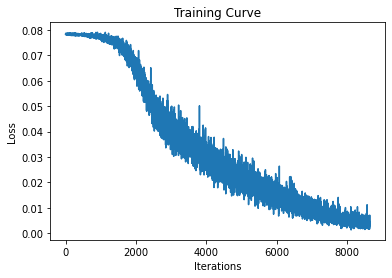

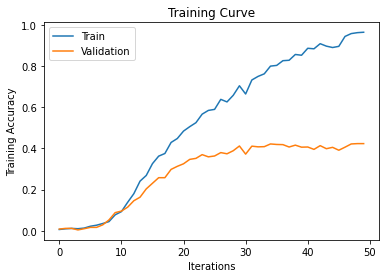

Final Training Accuracy: 0.9644541167936163
Final Validation Accuracy: 0.4233937397034596


In [8]:
model = PokemonClassifier(3)

#proper model
#############################################
#To Enable GPU Usage
if use_cuda and torch.cuda.is_available():
  model.cuda()
  print("cuda")
#############################################

#Basic first attempt at training
train(model, train_set, size=64, num_epochs=50, learning_rate=0.0005)

In [9]:
model = PokemonClassifier(3)

#proper model
#############################################
#To Enable GPU Usage
if use_cuda and torch.cuda.is_available():
  model.cuda()
  print("cuda")
#############################################

#Basic first attempt at training
train(model, train_set, size=32, num_epochs=50, learning_rate=0.002)

cuda
Epoch 0: Training Accuracy: 0.007526296699310845 Validation Accuracy: 0.008237232289950576
Epoch 1: Training Accuracy: 0.008342401160681901 Validation Accuracy: 0.007413509060955519
Epoch 2: Training Accuracy: 0.01405513239027929 Validation Accuracy: 0.018121911037891267
Epoch 3: Training Accuracy: 0.015868697859992745 Validation Accuracy: 0.011532125205930808
Epoch 4: Training Accuracy: 0.024483133841131665 Validation Accuracy: 0.02471169686985173
Epoch 5: Training Accuracy: 0.0397170837867247 Validation Accuracy: 0.044481054365733116
Epoch 6: Training Accuracy: 0.04688066739209285 Validation Accuracy: 0.03789126853377265
Epoch 7: Training Accuracy: 0.06728327892636925 Validation Accuracy: 0.07413509060955518
Epoch 8: Training Accuracy: 0.10500544069640914 Validation Accuracy: 0.10049423393739704
Epoch 9: Training Accuracy: 0.13275299238302501 Validation Accuracy: 0.12355848434925865
Epoch 10: Training Accuracy: 0.176278563656148 Validation Accuracy: 0.15650741350906094
Epoch 11:

KeyboardInterrupt: ignored